# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

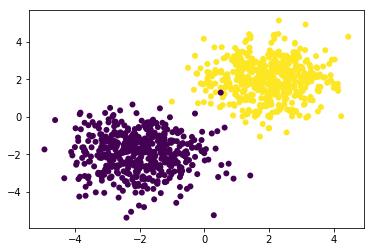

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

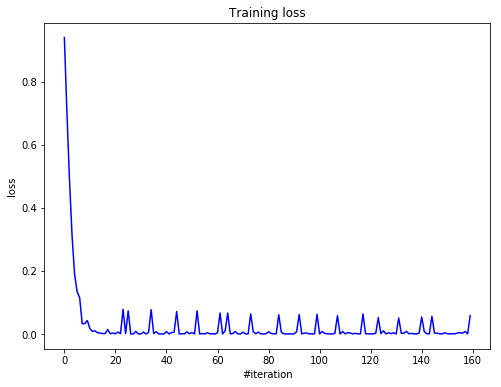

Current loss: 0.058190


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
def one_hot_labels(y):
    y_oh = np.zeros((len(y), 10))
    y_oh[np.arange(len(y)), y] = 1
    return y_oh

y_train = one_hot_labels(y_train)
y_val = one_hot_labels(y_val)
y_test = one_hot_labels(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***


## 1

In [10]:
# Your code goes here. ################################################

def train(net, optimizer_config, optimizer_state, batch_size=128, n_epoch=20, title=None, opt='sgd'):
    loss_history_train = []
    loss_history_val = []
    loss_history_test = []
    acc_history_train = []
    acc_history_val = []
    acc_history_test = []
    
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(n_epoch):
        loss_epoch = []
        acc_epoch = []
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            if opt == 'sgd':
                optimizer = sgd_momentum
            elif opt == 'adam':
                optimizer = adam_optimizer
            else:
                print('Try SGD or Adam')
            optimizer(net.getParameters(),
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      

            acc = (np.where(y_batch)[1] == predictions.argmax(axis=1)).mean()
            
            loss_epoch.append(loss)
            acc_epoch.append(acc)
            
            loss_history_train.append(loss)
            acc_history_train.append(acc)
        
        train_loss_epoch.append(np.array(loss_epoch).mean())
        train_acc_epoch.append(np.array(acc_epoch).mean())
        
        steps_train = len(X_train) / batch_size

        loss_val = 0
        correct_val = 0
        for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            correct = (np.where(y_batch)[1] == predictions.argmax(axis=1)).sum()
            
            loss_val += loss
            correct_val += correct
        
        loss_history_val.append((steps_train * (i + 1), loss_val / (len(X_val) / batch_size)))
        acc_history_val.append((steps_train * (i + 1), correct_val / len(X_val)))
        
        loss_test = 0
        correct_test = 0
        for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            correct = (np.where(y_batch)[1] == predictions.argmax(axis=1)).sum()
            
            loss_test += loss
            correct_test += correct
        
        loss_history_test.append((steps_train * (i + 1), loss_test / (len(X_test) / batch_size)))
        acc_history_test.append((steps_train * (i + 1), correct_test / len(X_test)))

        points_val_loss = np.array(loss_history_val)
        points_test_loss = np.array(loss_history_test)
        
        # Visualize
        
        # loss
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        
        if title:
            plt.title("Loss history: " + title)
        else:
            plt.title('Loss history')
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.plot(loss_history_train, label='train', zorder=1)
        plt.scatter(points_val_loss[:, 0], points_val_loss[:, 1], color='orange', marker='+', s=250, label='validation', zorder=2)
        plt.scatter(points_test_loss[:, 0], points_test_loss[:, 1], color='red', marker='x', s=250, label='test', zorder=2)
        plt.legend(loc='best')
        plt.show()

        # accuracy
        plt.figure(figsize=(8, 6))
        
        points_val_acc = np.array(acc_history_val)
        points_test_acc = np.array(acc_history_test)
        
        if title:
            plt.title("Accuracy history: " + title)
        else:
            plt.title("Accuracy history")
        plt.xlabel("iteration")
        plt.ylabel("accuracy")
        plt.plot(acc_history_train, label='train', zorder=1)
        plt.scatter(points_val_acc[:, 0], points_val_acc[:, 1], color='orange', marker='+', s=250, label='validation', zorder=2)
        plt.scatter(points_test_acc[:, 0], points_test_acc[:, 1], color='red', marker='x', s=250, label='test', zorder=2)
        plt.legend(loc='best')
        plt.show()
    
    print('Validation accuracy: %f' % acc_history_val[-1][1])
    print('Test accuracy: %f' % acc_history_test[-1][1])
    
    return train_loss_epoch, train_acc_epoch, points_val_loss[:, 1], points_val_acc[:, 1], points_test_loss[:, 1], points_test_acc[:, 1]

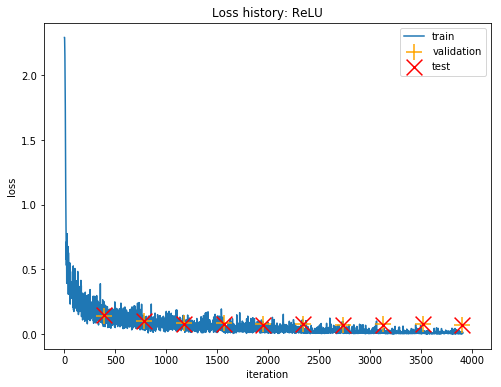

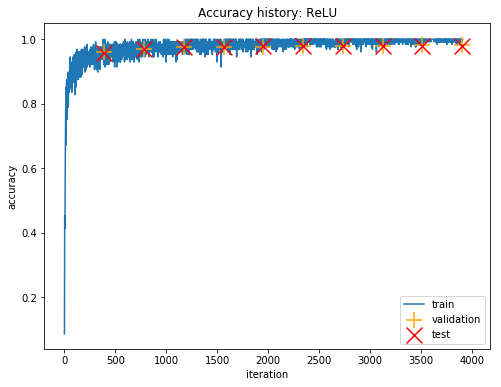

Validation accuracy: 0.980900
Test accuracy: 0.980000
Wall time: 39.3 s


In [11]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ReLU())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_relu, train_acc_relu, val_loss_relu, val_acc_relu, test_loss_relu, test_acc_relu =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ReLU')

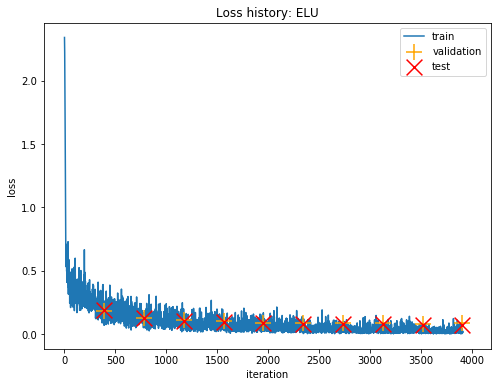

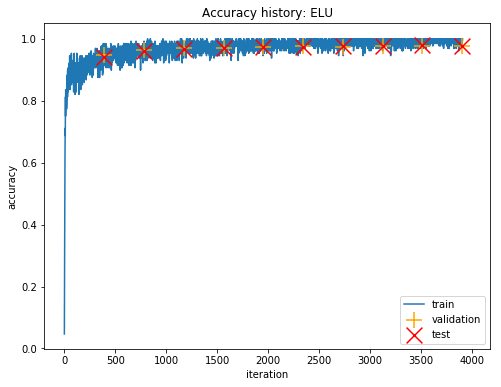

Validation accuracy: 0.976400
Test accuracy: 0.977200
Wall time: 39.8 s


In [12]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ELU())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_elu, train_acc_elu, val_loss_elu, val_acc_elu, test_loss_elu, test_acc_elu =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ELU')

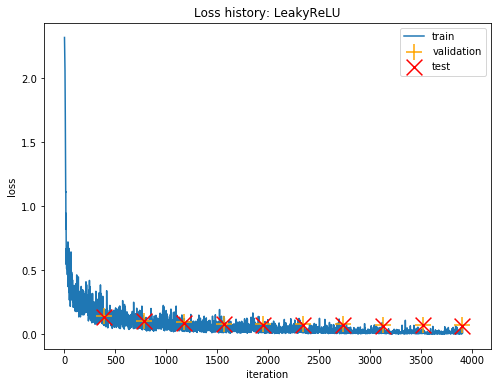

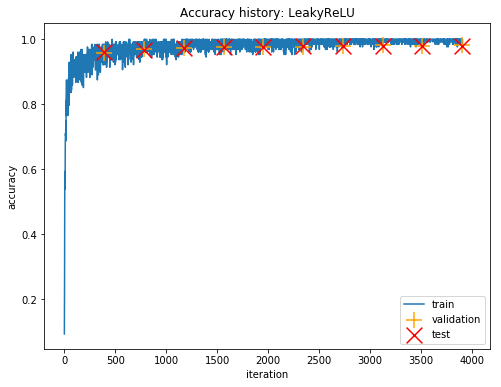

Validation accuracy: 0.981500
Test accuracy: 0.980800
Wall time: 37.1 s


In [13]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(LeakyReLU())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_leakyrelu, train_acc_leakyrelu, val_loss_leakyrelu, val_acc_leakyrelu, test_loss_leakyrelu, test_acc_leakyrelu =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU')

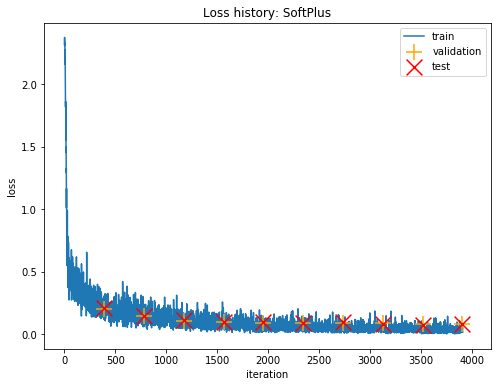

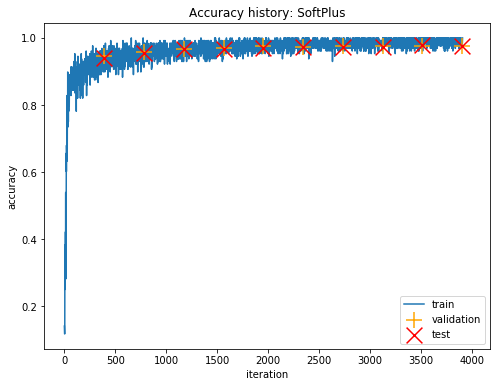

Validation accuracy: 0.977000
Test accuracy: 0.976100
Wall time: 40.4 s


In [14]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(SoftPlus())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_softplus, train_acc_softplus, val_loss_softplus, val_acc_softplus, test_loss_softplus, test_acc_softplus =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='SoftPlus')

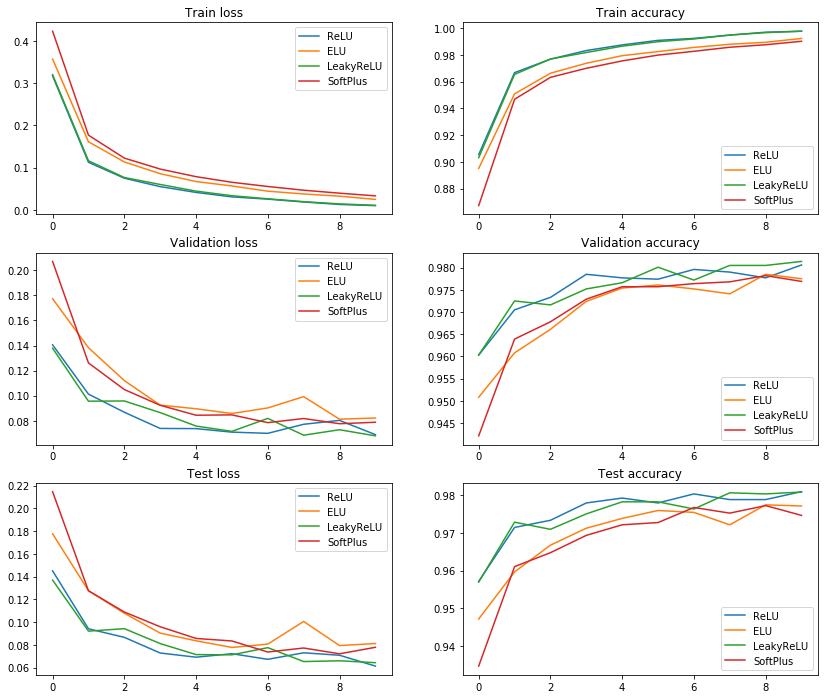

In [15]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].set_title('Train loss')
axes[0, 0].plot(train_loss_relu, label='ReLU')
axes[0, 0].plot(train_loss_elu, label='ELU')
axes[0, 0].plot(train_loss_leakyrelu, label='LeakyReLU')
axes[0, 0].plot(train_loss_softplus, label='SoftPlus')
axes[0, 0].legend(loc='best')

axes[1, 0].set_title('Validation loss')
axes[1, 0].plot(val_loss_relu, label='ReLU')
axes[1, 0].plot(val_loss_elu, label='ELU')
axes[1, 0].plot(val_loss_leakyrelu, label='LeakyReLU')
axes[1, 0].plot(val_loss_softplus, label='SoftPlus')
axes[1, 0].legend(loc='best')

axes[2, 0].set_title('Test loss')
axes[2, 0].plot(test_loss_relu, label='ReLU')
axes[2, 0].plot(test_loss_elu, label='ELU')
axes[2, 0].plot(test_loss_leakyrelu, label='LeakyReLU')
axes[2, 0].plot(test_loss_softplus, label='SoftPlus')
axes[2, 0].legend(loc='best')

axes[0, 1].set_title('Train accuracy')
axes[0, 1].plot(train_acc_relu, label='ReLU')
axes[0, 1].plot(train_acc_elu, label='ELU')
axes[0, 1].plot(train_acc_leakyrelu, label='LeakyReLU')
axes[0, 1].plot(train_acc_softplus, label='SoftPlus')
axes[0, 1].legend(loc='best')

axes[1, 1].set_title('Validation accuracy')
axes[1, 1].plot(val_acc_relu, label='ReLU')
axes[1, 1].plot(val_acc_elu, label='ELU')
axes[1, 1].plot(val_acc_leakyrelu, label='LeakyReLU')
axes[1, 1].plot(val_acc_softplus, label='SoftPlus')
axes[1, 1].legend(loc='best')

axes[2, 1].set_title('Test accuracy')
axes[2, 1].plot(test_acc_relu, label='ReLU')
axes[2, 1].plot(test_acc_elu, label='ELU')
axes[2, 1].plot(test_acc_leakyrelu, label='LeakyReLU')
axes[2, 1].plot(test_acc_softplus, label='SoftPlus')
axes[2, 1].legend(loc='best')

plt.show()

We can see that in our case LeakyReLU is slightly better than ReLU and other functions. The computation time for it is also the smallest, and for other activation functions it is a bit bigger.

## 2

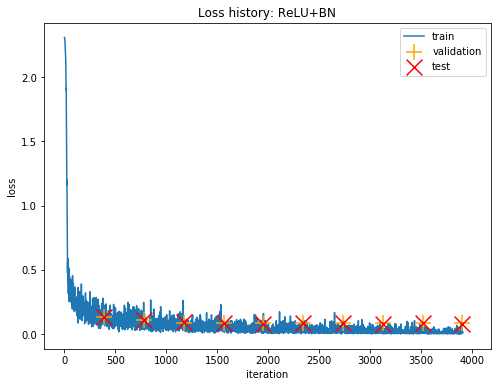

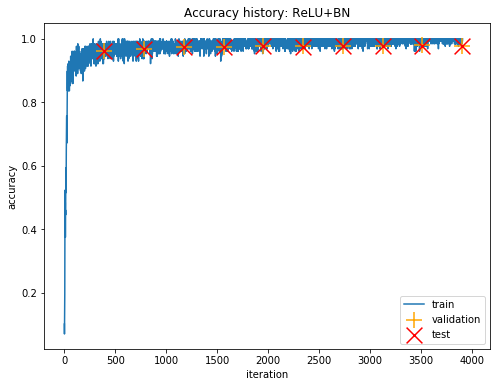

Validation accuracy: 0.978900
Test accuracy: 0.978400
Wall time: 42.6 s


In [15]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_relu_bn, train_acc_relu_bn, val_loss_relu_bn, val_acc_relu_bn, test_loss_relu_bn, test_acc_relu_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ReLU+BN')

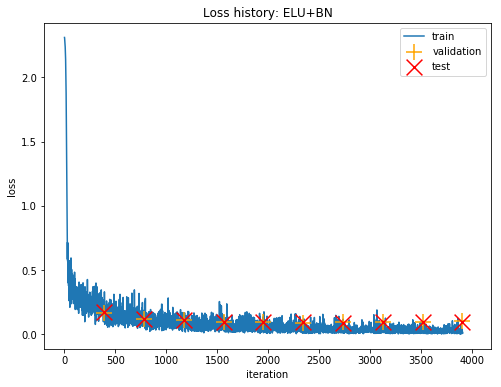

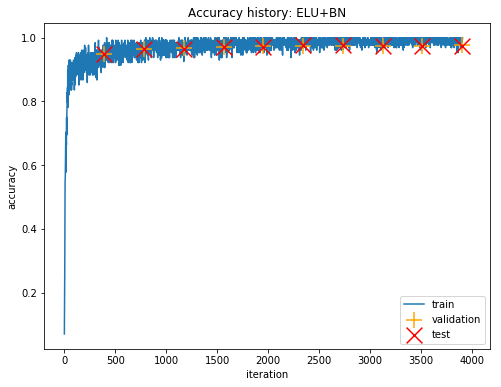

Validation accuracy: 0.975900
Test accuracy: 0.974900
Wall time: 43.9 s


In [16]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ELU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_elu_bn, train_acc_elu_bn, val_loss_elu_bn, val_acc_elu_bn, test_loss_elu_bn, test_acc_elu_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ELU+BN')

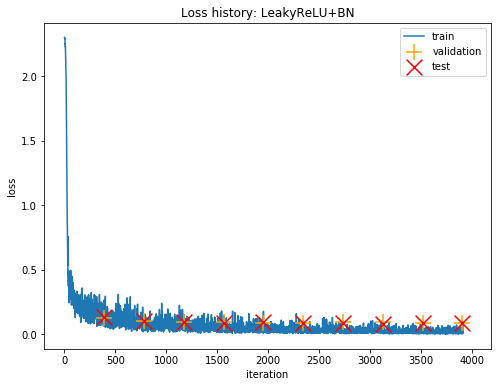

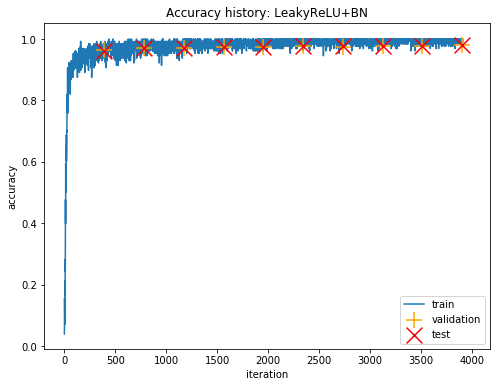

Validation accuracy: 0.979100
Test accuracy: 0.979200
Wall time: 41.4 s


In [17]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_leakyrelu_bn, train_acc_leakyrelu_bn, val_loss_leakyrelu_bn, val_acc_leakyrelu_bn, test_loss_leakyrelu_bn, test_acc_leakyrelu_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU+BN')

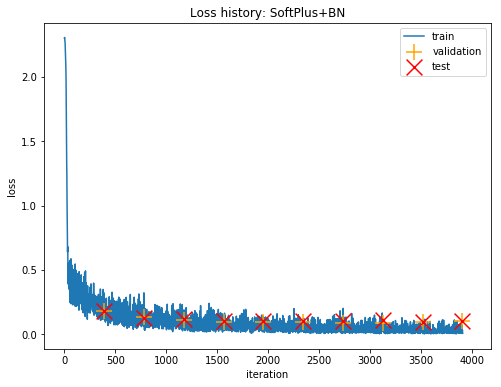

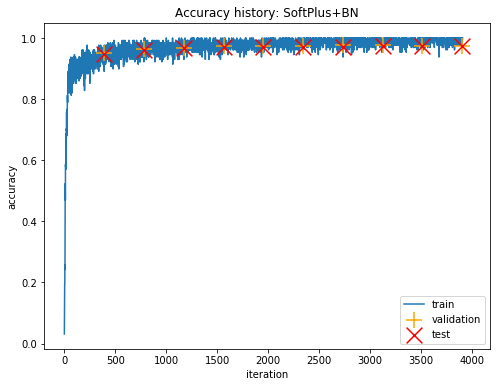

Validation accuracy: 0.974000
Test accuracy: 0.973000
Wall time: 44.4 s


In [18]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(SoftPlus())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_softplus_bn, train_acc_softplus_bn, val_loss_softplus_bn, val_acc_softplus_bn, test_loss_softplus_bn, test_acc_softplus_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='SoftPlus+BN')

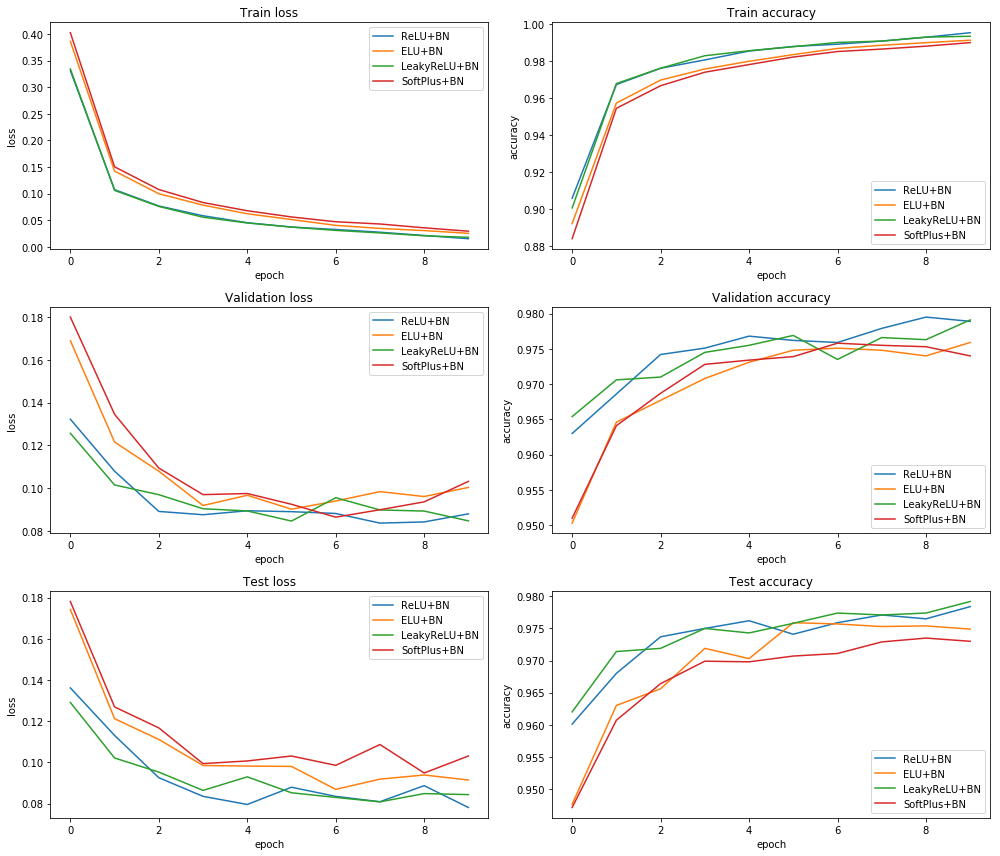

In [29]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].set_title('Train loss')
axes[0, 0].plot(train_loss_relu_bn, label='ReLU+BN')
axes[0, 0].plot(train_loss_elu_bn, label='ELU+BN')
axes[0, 0].plot(train_loss_leakyrelu_bn, label='LeakyReLU+BN')
axes[0, 0].plot(train_loss_softplus_bn, label='SoftPlus+BN')
axes[0, 0].legend(loc='best')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')

axes[1, 0].set_title('Validation loss')
axes[1, 0].plot(val_loss_relu_bn, label='ReLU+BN')
axes[1, 0].plot(val_loss_elu_bn, label='ELU+BN')
axes[1, 0].plot(val_loss_leakyrelu_bn, label='LeakyReLU+BN')
axes[1, 0].plot(val_loss_softplus_bn, label='SoftPlus+BN')
axes[1, 0].legend(loc='best')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('loss')

axes[2, 0].set_title('Test loss')
axes[2, 0].plot(test_loss_relu_bn, label='ReLU+BN')
axes[2, 0].plot(test_loss_elu_bn, label='ELU+BN')
axes[2, 0].plot(test_loss_leakyrelu_bn, label='LeakyReLU+BN')
axes[2, 0].plot(test_loss_softplus_bn, label='SoftPlus+BN')
axes[2, 0].legend(loc='best')
axes[2, 0].set_xlabel('epoch')
axes[2, 0].set_ylabel('loss')

axes[0, 1].set_title('Train accuracy')
axes[0, 1].plot(train_acc_relu_bn, label='ReLU+BN')
axes[0, 1].plot(train_acc_elu_bn, label='ELU+BN')
axes[0, 1].plot(train_acc_leakyrelu_bn, label='LeakyReLU+BN')
axes[0, 1].plot(train_acc_softplus_bn, label='SoftPlus+BN')
axes[0, 1].legend(loc='best')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('accuracy')

axes[1, 1].set_title('Validation accuracy')
axes[1, 1].plot(val_acc_relu_bn, label='ReLU+BN')
axes[1, 1].plot(val_acc_elu_bn, label='ELU+BN')
axes[1, 1].plot(val_acc_leakyrelu_bn, label='LeakyReLU+BN')
axes[1, 1].plot(val_acc_softplus_bn, label='SoftPlus+BN')
axes[1, 1].legend(loc='best')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy')

axes[2, 1].set_title('Test accuracy')
axes[2, 1].plot(test_acc_relu_bn, label='ReLU+BN')
axes[2, 1].plot(test_acc_elu_bn, label='ELU+BN')
axes[2, 1].plot(test_acc_leakyrelu_bn, label='LeakyReLU+BN')
axes[2, 1].plot(test_acc_softplus_bn, label='SoftPlus+BN')
axes[2, 1].legend(loc='best')
axes[2, 1].set_xlabel('epoch')
axes[2, 1].set_ylabel('accuracy')

plt.tight_layout()
plt.show()

As in the previous case, the network with LeakyReLU performs the best. However, after adding BN we can see a slight drop in quality for each activation function, and also in computation time. But this drop is really tiny. Let's take a closer look at the results for LeakyReLU.

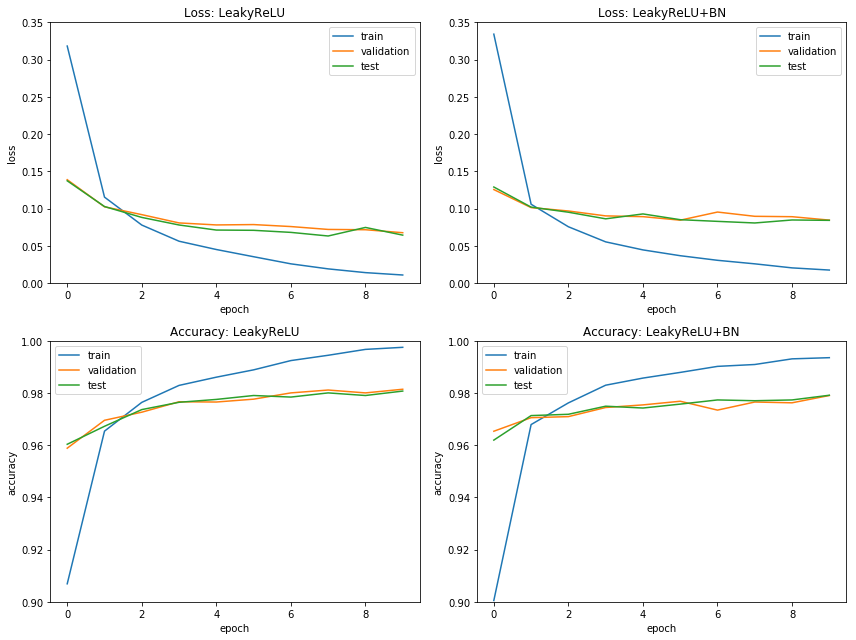

In [33]:
f, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0, 0].set_title('Loss: LeakyReLU')
axes[0, 0].plot(train_loss_leakyrelu, label='train')
axes[0, 0].plot(val_loss_leakyrelu, label='validation')
axes[0, 0].plot(test_loss_leakyrelu, label='test')
axes[0, 0].legend(loc='best')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].set_ylim([0, 0.35])

axes[0, 1].set_title('Loss: LeakyReLU+BN')
axes[0, 1].plot(train_loss_leakyrelu_bn, label='train')
axes[0, 1].plot(val_loss_leakyrelu_bn, label='validation')
axes[0, 1].plot(test_loss_leakyrelu_bn, label='test')
axes[0, 1].legend(loc='best')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('loss')
axes[0, 1].set_ylim([0, 0.35])

axes[1, 0].set_title('Accuracy: LeakyReLU')
axes[1, 0].plot(train_acc_leakyrelu, label='train')
axes[1, 0].plot(val_acc_leakyrelu, label='validation')
axes[1, 0].plot(test_acc_leakyrelu, label='test')
axes[1, 0].legend(loc='best')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('accuracy')
axes[1, 0].set_ylim([0.9, 1])

axes[1, 1].set_title('Accuracy: LeakyReLU+BN')
axes[1, 1].plot(train_acc_leakyrelu_bn, label='train')
axes[1, 1].plot(val_acc_leakyrelu_bn, label='validation')
axes[1, 1].plot(test_acc_leakyrelu_bn, label='test')
axes[1, 1].legend(loc='best')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy')
axes[1, 1].set_ylim([0.9, 1])

plt.tight_layout()
plt.show()

It can be seen from the plot that BN actually reduces overfitting of the network a little (the gap between training results and validation/test results is smaller) while maintaining the same quality for validation/test. So, in this case BatchNormalization helps to reduce overfitting, but doesn't help to achieve better quality.

## 3

For tasks 3-4 I take the best network achitecture so far in my opinion - with LeakyReLU activation function and BatchNormalization.

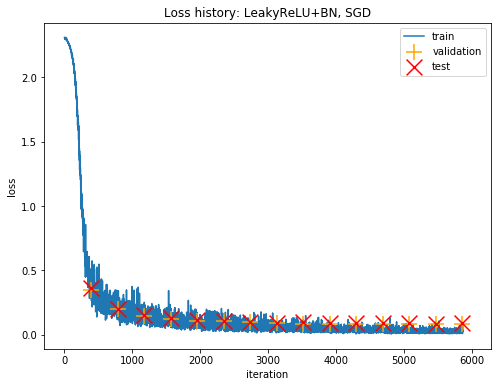

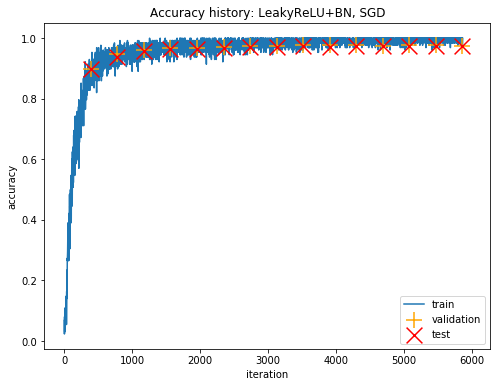

Validation accuracy: 0.975500
Test accuracy: 0.974600
Wall time: 1min 2s


In [65]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.99}
optimizer_state = {}

train_loss_leakyrelu_bn_sgd, train_acc_leakyrelu_bn_sgd, val_loss_leakyrelu_bn_sgd, val_acc_leakyrelu_bn_sgd, test_loss_leakyrelu_bn_sgd, test_acc_leakyrelu_bn_sgd =\
                    train(net, optimizer_config, optimizer_state, n_epoch=15, title='LeakyReLU+BN, SGD')

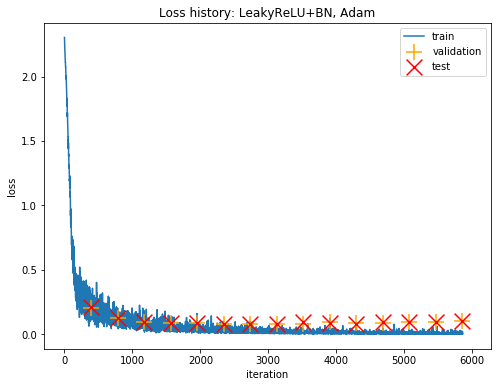

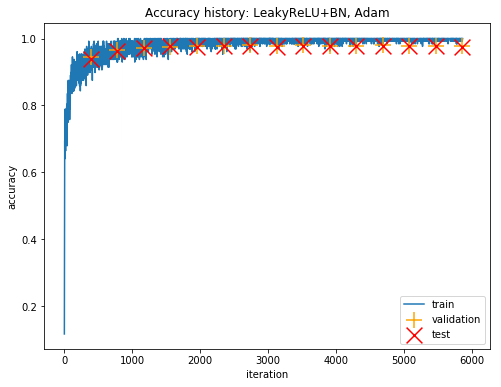

Validation accuracy: 0.976700
Test accuracy: 0.975400
Wall time: 1min 39s


In [66]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-12}
optimizer_state = {}

train_loss_leakyrelu_bn_adam, train_acc_leakyrelu_bn_adam, val_loss_leakyrelu_bn_adam, val_acc_leakyrelu_bn_adam, test_loss_leakyrelu_bn_adam, test_acc_leakyrelu_bn_adam =\
                    train(net, optimizer_config, optimizer_state, n_epoch=15, title='LeakyReLU+BN, Adam', opt='adam')

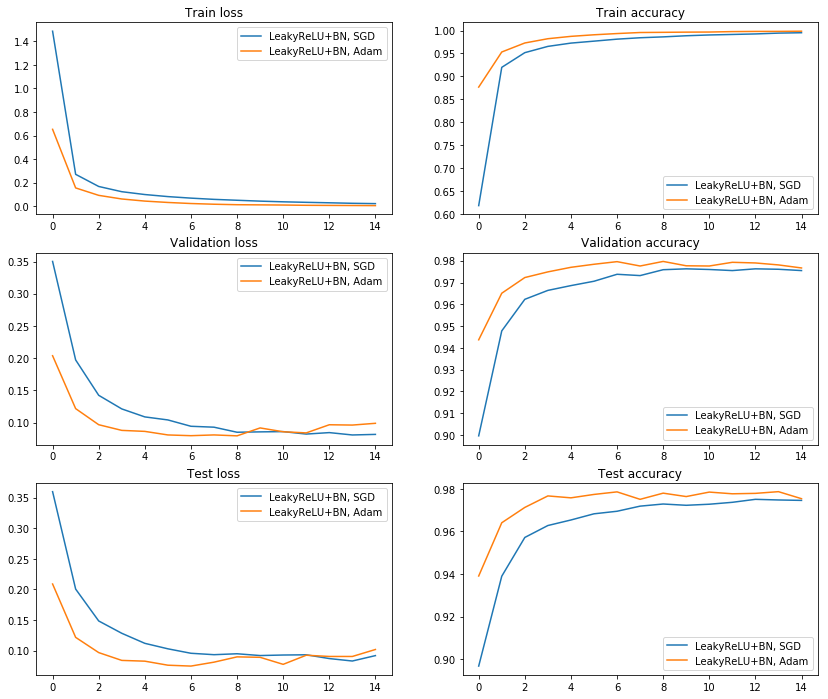

In [67]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].set_title('Train loss')
axes[0, 0].plot(train_loss_leakyrelu_bn_sgd, label='LeakyReLU+BN, SGD')
axes[0, 0].plot(train_loss_leakyrelu_bn_adam, label='LeakyReLU+BN, Adam')
axes[0, 0].legend(loc='best')

axes[1, 0].set_title('Validation loss')
axes[1, 0].plot(val_loss_leakyrelu_bn_sgd, label='LeakyReLU+BN, SGD')
axes[1, 0].plot(val_loss_leakyrelu_bn_adam, label='LeakyReLU+BN, Adam')
axes[1, 0].legend(loc='best')

axes[2, 0].set_title('Test loss')
axes[2, 0].plot(test_loss_leakyrelu_bn_sgd, label='LeakyReLU+BN, SGD')
axes[2, 0].plot(test_loss_leakyrelu_bn_adam, label='LeakyReLU+BN, Adam')
axes[2, 0].legend(loc='best')

axes[0, 1].set_title('Train accuracy')
axes[0, 1].plot(train_acc_leakyrelu_bn_sgd, label='LeakyReLU+BN, SGD')
axes[0, 1].plot(train_acc_leakyrelu_bn_adam, label='LeakyReLU+BN, Adam')
axes[0, 1].legend(loc='best')

axes[1, 1].set_title('Validation accuracy')
axes[1, 1].plot(val_acc_leakyrelu_bn_sgd, label='LeakyReLU+BN, SGD')
axes[1, 1].plot(val_acc_leakyrelu_bn_adam, label='LeakyReLU+BN, Adam')
axes[1, 1].legend(loc='best')

axes[2, 1].set_title('Test accuracy')
axes[2, 1].plot(test_acc_leakyrelu_bn_sgd, label='LeakyReLU+BN, SGD')
axes[2, 1].plot(test_acc_leakyrelu_bn_adam, label='LeakyReLU+BN, Adam')
axes[2, 1].legend(loc='best')

plt.show()

We can see that the network trained with Adam has a slightly better performance, than with SGD, however, it requires more time to train.

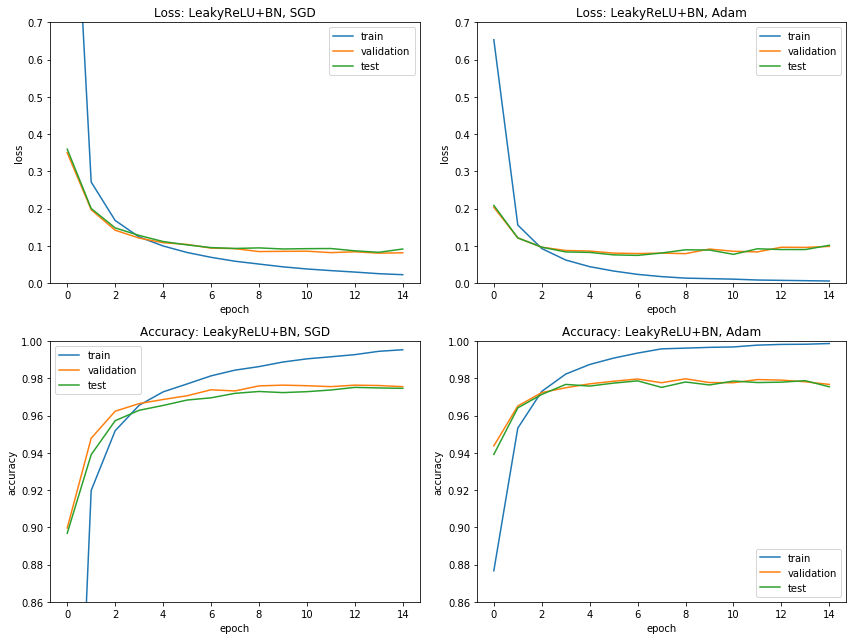

In [71]:
f, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0, 0].set_title('Loss: LeakyReLU+BN, SGD')
axes[0, 0].plot(train_loss_leakyrelu_bn_sgd, label='train')
axes[0, 0].plot(val_loss_leakyrelu_bn_sgd, label='validation')
axes[0, 0].plot(test_loss_leakyrelu_bn_sgd, label='test')
axes[0, 0].legend(loc='best')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].set_ylim([0, 0.7])

axes[0, 1].set_title('Loss: LeakyReLU+BN, Adam')
axes[0, 1].plot(train_loss_leakyrelu_bn_adam, label='train')
axes[0, 1].plot(val_loss_leakyrelu_bn_adam, label='validation')
axes[0, 1].plot(test_loss_leakyrelu_bn_adam, label='test')
axes[0, 1].legend(loc='best')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('loss')
axes[0, 1].set_ylim([0, 0.7])

axes[1, 0].set_title('Accuracy: LeakyReLU+BN, SGD')
axes[1, 0].plot(train_acc_leakyrelu_bn_sgd, label='train')
axes[1, 0].plot(val_acc_leakyrelu_bn_sgd, label='validation')
axes[1, 0].plot(test_acc_leakyrelu_bn_sgd, label='test')
axes[1, 0].legend(loc='best')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('accuracy')
axes[1, 0].set_ylim([0.86, 1])

axes[1, 1].set_title('Accuracy: LeakyReLU+BN, Adam')
axes[1, 1].plot(train_acc_leakyrelu_bn_adam, label='train')
axes[1, 1].plot(val_acc_leakyrelu_bn_adam, label='validation')
axes[1, 1].plot(test_acc_leakyrelu_bn_adam, label='test')
axes[1, 1].legend(loc='best')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy')
axes[1, 1].set_ylim([0.86, 1])

plt.tight_layout()
plt.show()

This plot demonstrates that although Adam gives a slightly better performance, it has a bigger gap between training quality and validation/test quality, which implies that we have to be more careful with it in terms of overfitting.

## 4

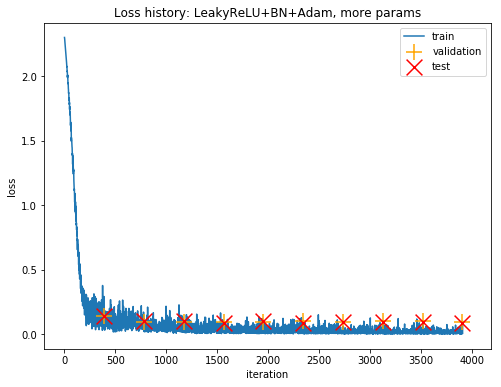

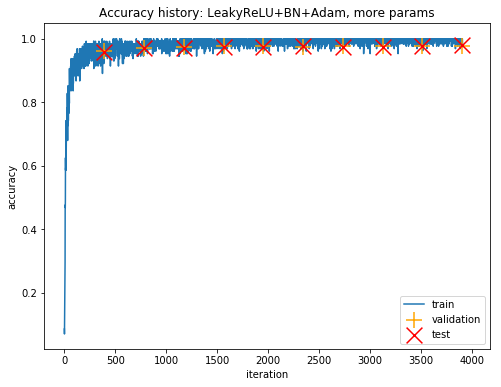

Validation accuracy: 0.977500
Test accuracy: 0.979200
Wall time: 2min 31s


In [75]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 512))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(512))
net.add(Linear(512, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 128))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-12}
optimizer_state = {}

train_loss_big, train_acc_big, val_loss_big, val_acc_big, test_loss_big, test_acc_big =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU+BN+Adam, more params', opt='adam')

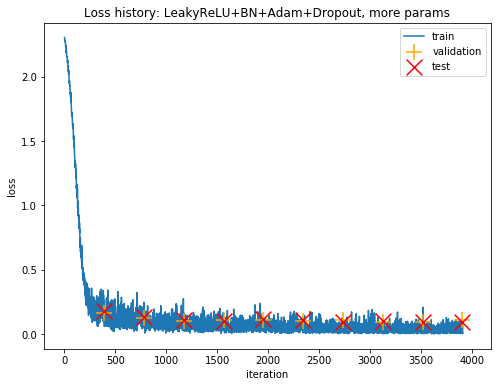

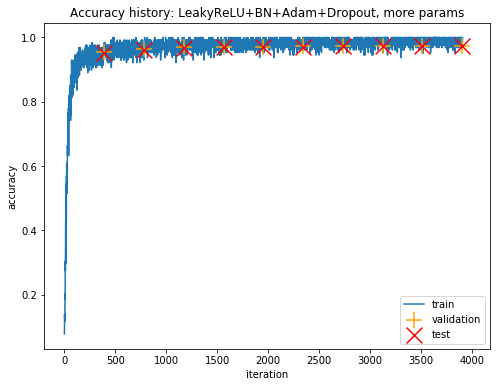

Validation accuracy: 0.972300
Test accuracy: 0.972900
Wall time: 2min 46s


In [79]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 512))
net.add(LeakyReLU())
net.add(Dropout(0.2))
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(512))
net.add(Linear(512, 256))
net.add(LeakyReLU())
net.add(Dropout(0.2))
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 128))
net.add(LeakyReLU())
net.add(Dropout(0.2))
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-12}
optimizer_state = {}

train_loss_dp_big, train_acc_dp_big, val_loss_dp_big, val_acc_dp_big, test_loss_dp_big, test_acc_dp_big =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU+BN+Adam+Dropout, more params', opt='adam')

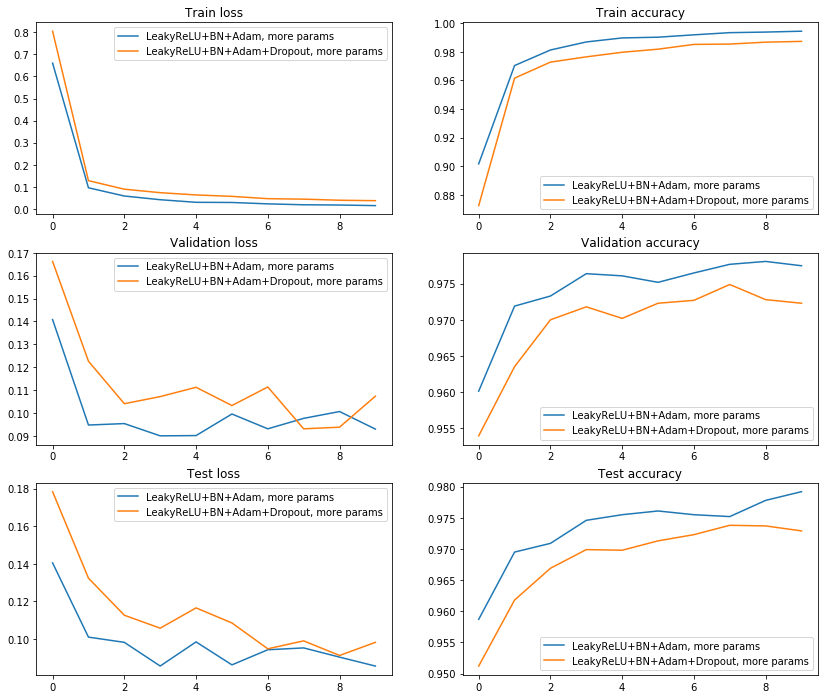

In [81]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].set_title('Train loss')
axes[0, 0].plot(train_loss_big, label='LeakyReLU+BN+Adam, more params')
axes[0, 0].plot(train_loss_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[0, 0].legend(loc='best')

axes[1, 0].set_title('Validation loss')
axes[1, 0].plot(val_loss_big, label='LeakyReLU+BN+Adam, more params')
axes[1, 0].plot(val_loss_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[1, 0].legend(loc='best')

axes[2, 0].set_title('Test loss')
axes[2, 0].plot(test_loss_big, label='LeakyReLU+BN+Adam, more params')
axes[2, 0].plot(test_loss_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[2, 0].legend(loc='best')

axes[0, 1].set_title('Train accuracy')
axes[0, 1].plot(train_acc_big, label='LeakyReLU+BN+Adam, more params')
axes[0, 1].plot(train_acc_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[0, 1].legend(loc='best')

axes[1, 1].set_title('Validation accuracy')
axes[1, 1].plot(val_acc_big, label='LeakyReLU+BN+Adam, more params')
axes[1, 1].plot(val_acc_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[1, 1].legend(loc='best')

axes[2, 1].set_title('Test accuracy')
axes[2, 1].plot(test_acc_big, label='LeakyReLU+BN+Adam, more params')
axes[2, 1].plot(test_acc_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[2, 1].legend(loc='best')

plt.show()

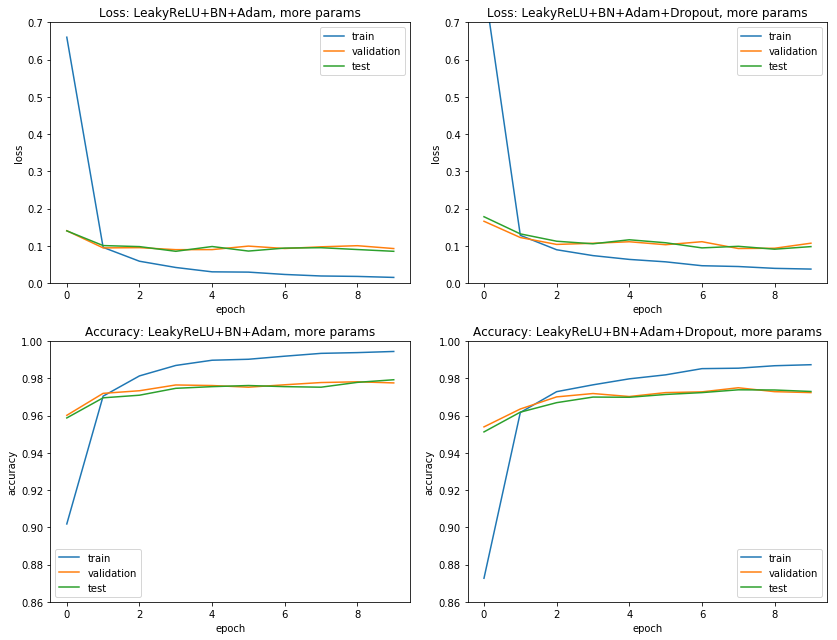

In [87]:
f, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0, 0].set_title('Loss: LeakyReLU+BN+Adam, more params')
axes[0, 0].plot(train_loss_big, label='train')
axes[0, 0].plot(val_loss_big, label='validation')
axes[0, 0].plot(test_loss_big, label='test')
axes[0, 0].legend(loc='best')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].set_ylim([0, 0.7])

axes[0, 1].set_title('Loss: LeakyReLU+BN+Adam+Dropout, more params')
axes[0, 1].plot(train_loss_dp_big, label='train')
axes[0, 1].plot(val_loss_dp_big, label='validation')
axes[0, 1].plot(test_loss_dp_big, label='test')
axes[0, 1].legend(loc='best')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('loss')
axes[0, 1].set_ylim([0, 0.7])

axes[1, 0].set_title('Accuracy: LeakyReLU+BN+Adam, more params')
axes[1, 0].plot(train_acc_big, label='train')
axes[1, 0].plot(val_acc_big, label='validation')
axes[1, 0].plot(test_acc_big, label='test')
axes[1, 0].legend(loc='best')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('accuracy')
axes[1, 0].set_ylim([0.86, 1])

axes[1, 1].set_title('Accuracy: LeakyReLU+BN+Adam+Dropout, more params')
axes[1, 1].plot(train_acc_dp_big, label='train')
axes[1, 1].plot(val_acc_dp_big, label='validation')
axes[1, 1].plot(test_acc_dp_big, label='test')
axes[1, 1].legend(loc='best')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy')
axes[1, 1].set_ylim([0.86, 1])

plt.tight_layout()
plt.show()

We can see that in this task adding dropout drops performance a little and requires a little bit more time to train the network. Validation and test performances are approximately same in both cases. However, a gap between train and validation/test performances is bigger without dropout, which means that it converges faster in terms of train.

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

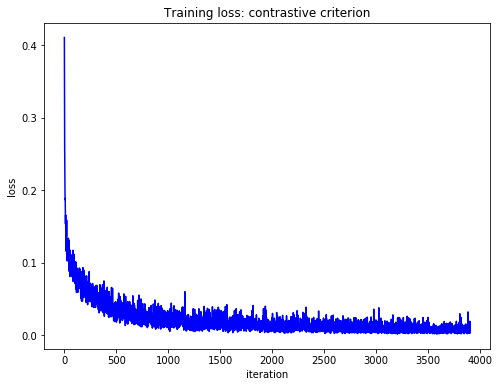

Current loss: 0.014696
Wall time: 2min 54s


In [98]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 512))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(512))
net.add(Linear(512, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 128))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(128))

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-12}
optimizer_state = {}

criterion = ClassContrastiveCriterion(M=1)

loss_history = []

n_epoch = 10

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch.argmax(axis=1))
    
        # Backward
        dp = criterion.backward(predictions, y_batch.argmax(axis=1))
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                       net.getGradParameters(), 
                       optimizer_config,
                       optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss: contrastive criterion")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

5006741.0 44988259.0
Bhattacharyya coefficient: 0.18740981763232134
Wall time: 2min 33s


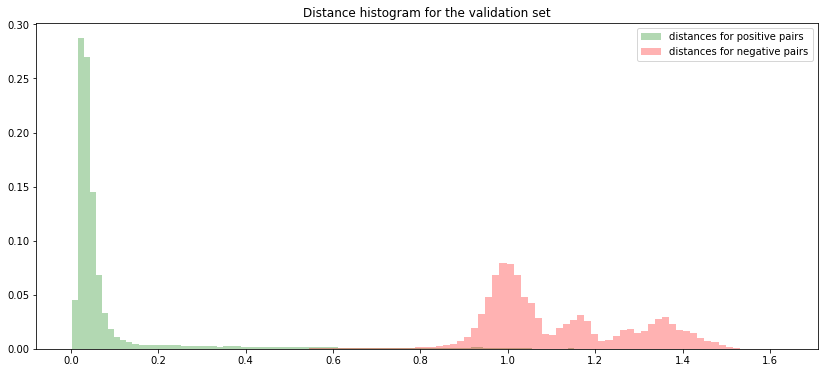

In [99]:
%%time

#features : 'number of examples' * 'dimensionality'
f = net.forward(X_val)
labels = y_val.argmax(axis=1)

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b = np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

plt.figure(figsize=(14, 6))
plt.title('Distance histogram for the validation set')
hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))

print('Bhattacharyya coefficient:', bhattacharyya)

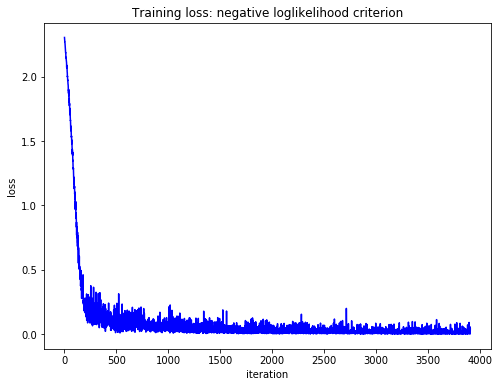

Current loss: 0.038435
Wall time: 2min 22s


In [100]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 512))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(512))
net.add(Linear(512, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 128))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-12}
optimizer_state = {}

criterion = ClassNLLCriterion()

loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                       net.getGradParameters(), 
                       optimizer_config,
                       optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss: negative loglikelihood criterion")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

5006741.0 44988259.0
Bhattacharyya coefficient: 0.520599686589744
Wall time: 2min 45s


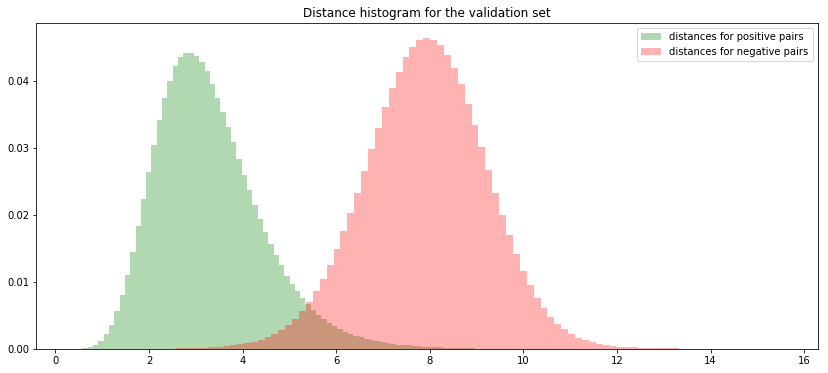

In [103]:
%%time

def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for l in network:
        input = l.forward(input)
        activations.append(input)

    return activations

#features : 'number of examples' * 'dimensionality'
f = forward(net, X_val)[-3]
labels = y_val.argmax(axis=1)

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b = np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

plt.figure(figsize=(14, 6))
plt.title('Distance histogram for the validation set')
hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))

print('Bhattacharyya coefficient:', bhattacharyya)

According to the plots and to the fact that Bhattacharyya coefficient for Contrastive criterion is lower than for NLL, we can conclude that Contrastive criterion produces better embeddings in comparison with negative loglikelihood criterion.